In [3]:
import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

In [4]:
import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt

%matplotlib inline
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.detuners_cython import Chromaticity, AmplitudeDetuning
import PyHEADTAIL.particles.generators as generators

try:
    from PySussix import Sussix
except ImportError as em:
    print em
    print ('trying PySUSSIX...')
    from PySUSSIX import Sussix



No module named PySussix
trying PySUSSIX...


In [5]:
# HELPERS
def calc_sussix_spec(x, xp, y, yp, p_idx, turn, window_width, q_x, q_y, n_lines=10):

    # Initialise Sussix object
    SX = Sussix()
    SX.sussix_inp(nt1=1, nt2=window_width, idam=2, ir=0, tunex=q_x, tuney=q_y)

    tunes_x = np.empty(n_lines)
    tunes_y = np.empty(n_lines)

    SX.sussix(x[p_idx,turn:turn+window_width], xp[p_idx,turn:turn+window_width],
              y[p_idx,turn:turn+window_width], yp[p_idx,turn:turn+window_width],
              x[p_idx,turn:turn+window_width], xp[p_idx,turn:turn+window_width]) # this line is not used by sussix!

    return SX.ox[:n_lines], SX.oy[:n_lines]

def track_n_save(bunch, map_):
    n_particles = bunch.macroparticlenumber
    x_i = np.empty((n_particles, n_turns))
    xp_i = np.empty((n_particles, n_turns))
    y_i = np.empty((n_particles, n_turns))
    yp_i = np.empty((n_particles, n_turns))

    for i in xrange(n_turns):
        x_i[:,i] = bunch.x[:]
        xp_i[:,i] = bunch.xp[:]
        y_i[:,i] = bunch.y[:]
        yp_i[:,i] = bunch.yp[:]
   
        for m_ in map_:
            m_.track(bunch)

    return x_i, xp_i, y_i, yp_i

def analyse_n_plot(bunch, x_i, xp_i, y_i, yp_i):
    ox = np.empty(bunch.macroparticlenumber)
    oy = np.empty(bunch.macroparticlenumber)
    print 'analysing particle spectra ... this may take some time.'
    for p_idx in range(bunch.macroparticlenumber):
        ox[p_idx], oy[p_idx] = calc_sussix_spec(x_i, xp_i, y_i, yp_i, p_idx,
                                   turn=0, window_width=512, q_x=Q_x%1, q_y=Q_y%1, n_lines=1)
        if (p_idx)%100 == 0:
            print 'particle', p_idx

    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312, sharex=ax1)
    ax3 = fig.add_subplot(313)

    ax1.scatter(ox, oy)
    ax1.set_ylabel(r'$Q_y$')
    ax1.set_xlabel(r'$Q_x$')
    ax2.hist(ox, bins=50, color='blue')
    ax2.set_xlabel(r'$Q_x$')
    ax3.hist(oy, bins=50, color='red')
    ax3.set_xlabel(r'$Q_y$')
    
    print 'std dev. Qx', np.std(ox)
    print 'std dev. Qy', np.std(oy)
    plt.show()

def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, alpha_0, Q_s, R):
    intensity = 1.05e11
    sigma_z = 0.059958
    gamma = 3730.26
    eta = alpha_0 - 1. / gamma**2
    gamma_t = 1. / np.sqrt(alpha_0)
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = eta * R / Q_s

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e)
    
    bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=C,
        alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
        alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)
    #print bunch.sigma_z()

    return bunch

In [6]:
# Basic parameters.
n_turns = 1024
n_segments = 1
n_macroparticles = 500

Q_x = 64.28
Q_y = 59.31
Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376
alpha_0 = 0.0003225

In [7]:
# Parameters for transverse map.
s = np.arange(0, n_segments + 1) * C / n_segments

alpha_x = alpha_x_inj * np.ones(n_segments)
beta_x = beta_x_inj * np.ones(n_segments)
D_x = np.zeros(n_segments)

alpha_y = alpha_y_inj * np.ones(n_segments)
beta_y = beta_y_inj * np.ones(n_segments)
D_y = np.zeros(n_segments)

analysing particle spectra ... this may take some time.
particle 0
particle 100
particle 200
particle 300
particle 400
std dev. Qx 1.63852601873e-06
std dev. Qy 5.17191785092e-07


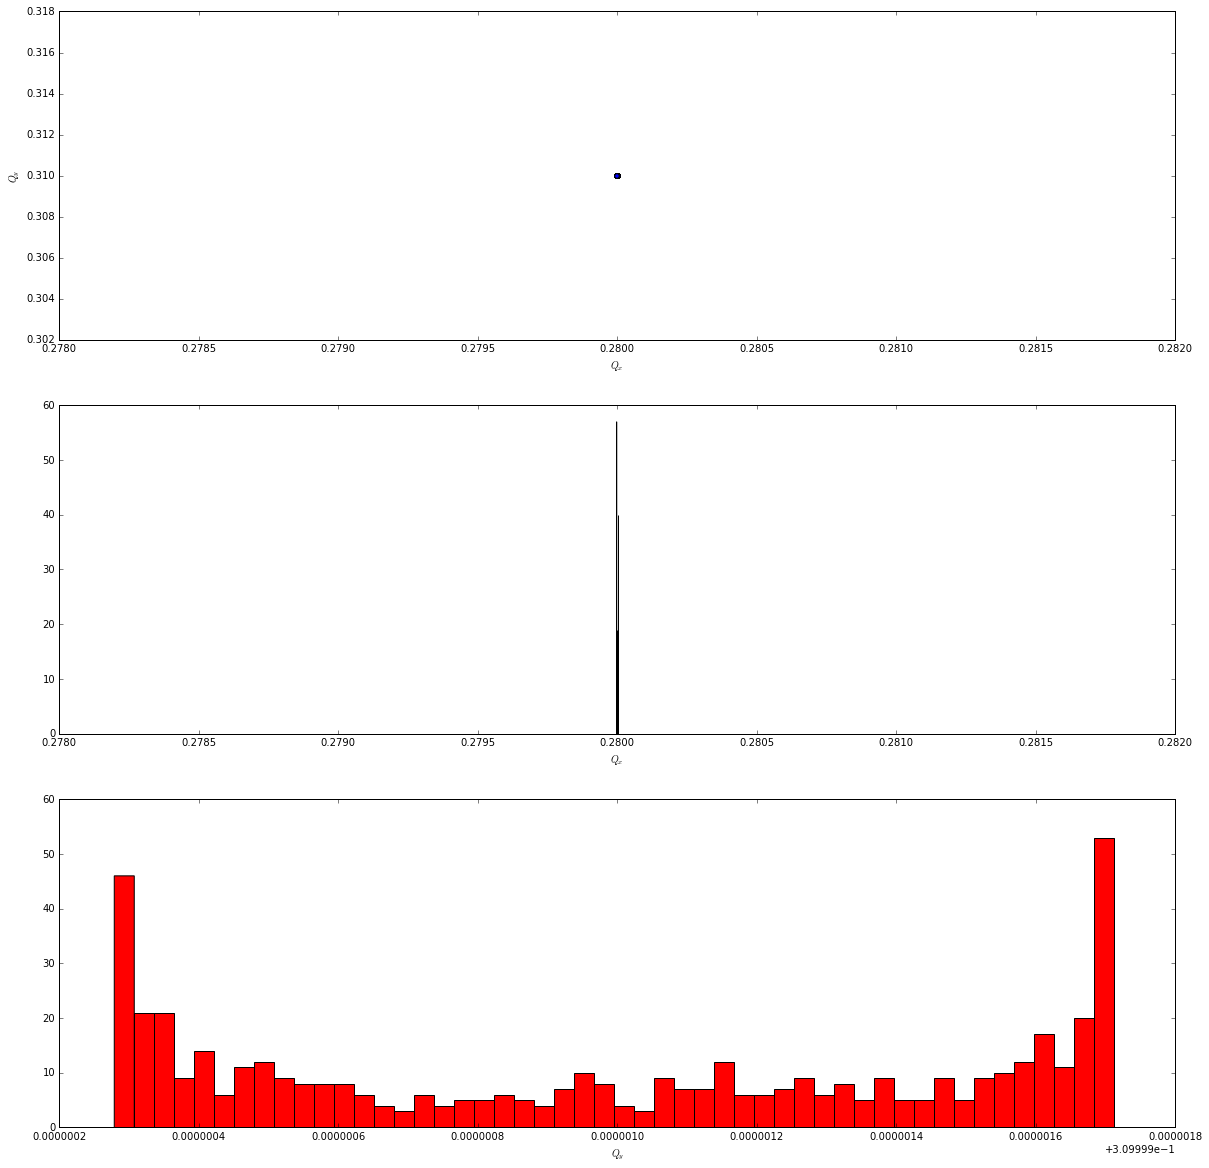

In [8]:
# CASE I
# With amplitude detuning (python implementation)

# EXPECTED TUNE SPREADS AT THE GIVEN SETTINGS ARE 5e-4 FOR HORIZONTAL
# AND VERTICAL.
bunch = generate_bunch(
    n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,
    alpha_0, Q_s, R)

ampl_det = AmplitudeDetuning.from_octupole_currents_LHC(i_focusing=400, i_defocusing=-400)
trans_map = TransverseMap(
    s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y, ampl_det)

trans_one_turn = [ m for m in trans_map ]
map_ = trans_one_turn

x_i, xp_i, y_i, yp_i = track_n_save(bunch, map_)
analyse_n_plot(bunch, x_i, xp_i, y_i, yp_i)

analysing particle spectra ... this may take some time.
particle 0
particle 100
particle 200
particle 300
particle 400
std dev. Qx 1.65237274877e-06
std dev. Qy 5.19141858086e-07


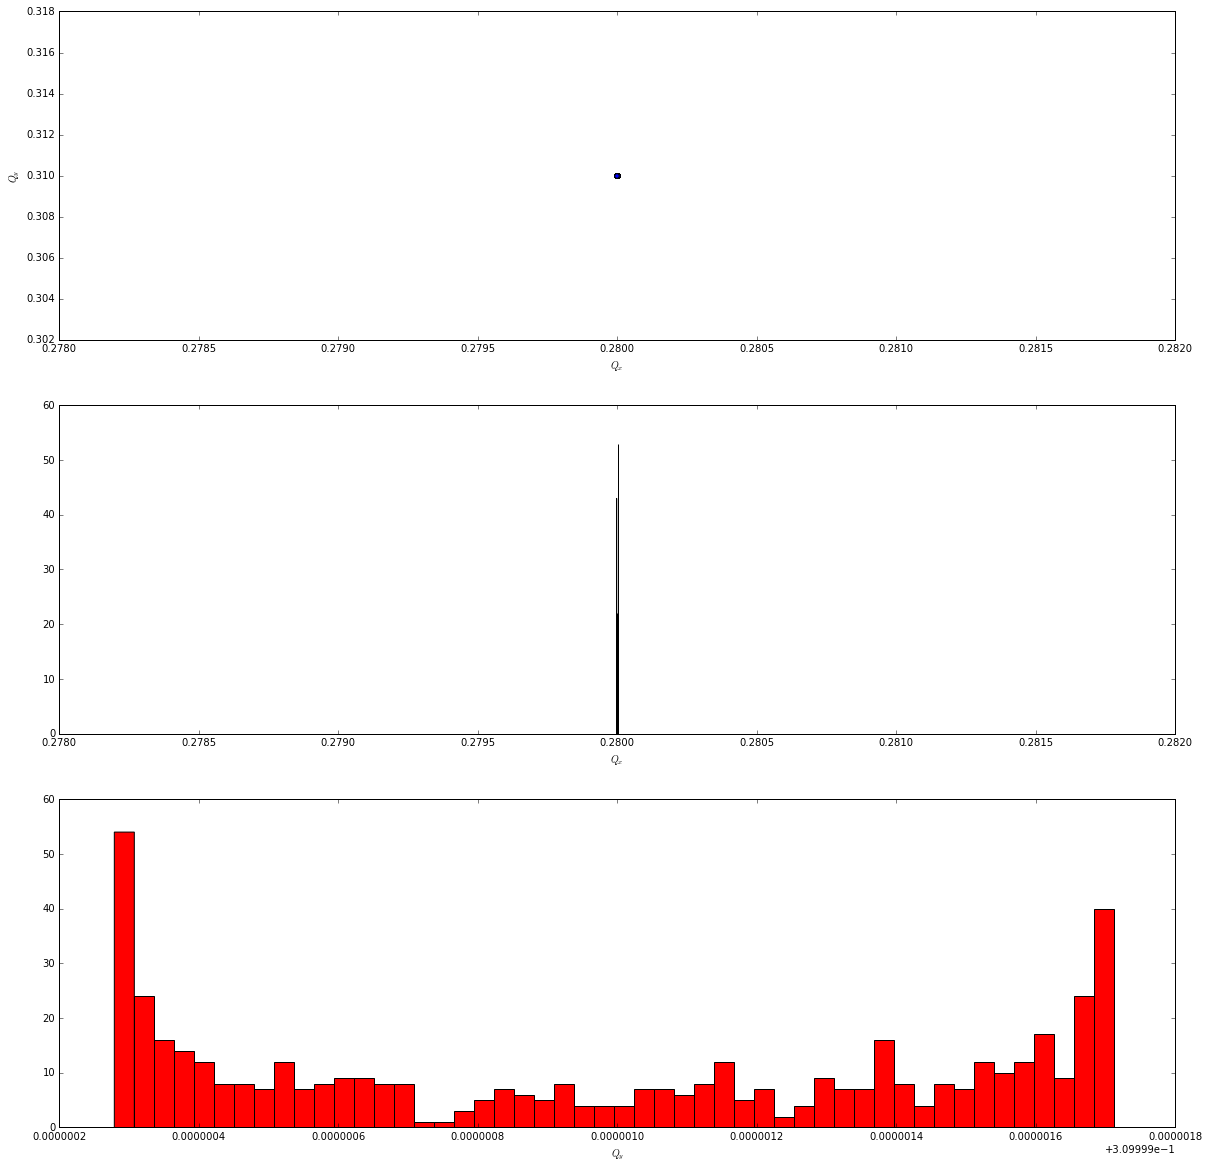

In [9]:
# CASE II
# With first order Chromaticity (python implementation)
bunch = generate_bunch(
    n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,
    alpha_0, Q_s, R)

chroma = Chromaticity(Qp_x=[6], Qp_y=[3])
trans_map = TransverseMap(
    s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y, chroma)

trans_one_turn = [ m for m in trans_map ]
map_ = trans_one_turn

x_i, xp_i, y_i, yp_i = track_n_save(bunch, map_)
analyse_n_plot(bunch, x_i, xp_i, y_i, yp_i)

analysing particle spectra ... this may take some time.
particle 0
particle 100
particle 200
particle 300
particle 400
std dev. Qx 1.63798471612e-06
std dev. Qy 5.08892243162e-07


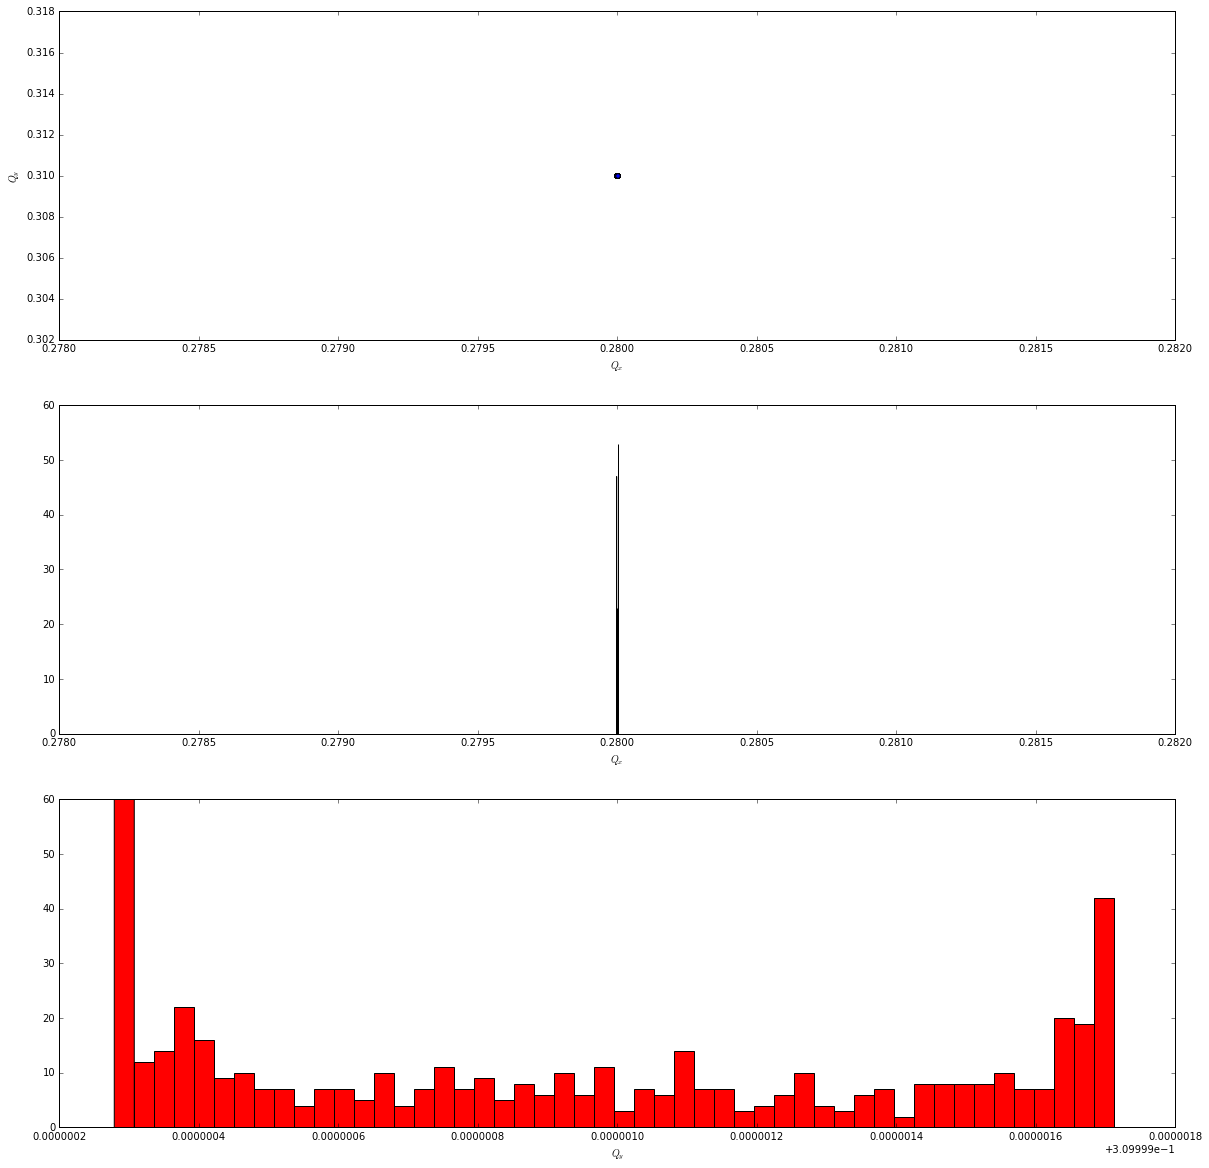

In [10]:
# CASE III
# With higher order Chromaticity (python implementation)
bunch = generate_bunch(
    n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,
    alpha_0, Q_s, R)

chroma = Chromaticity(Qp_x=[6., 4e4], Qp_y=[3., 0., 2e8])
trans_map = TransverseMap(
    s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y, chroma)

trans_one_turn = [ m for m in trans_map ]
map_ = trans_one_turn

x_i, xp_i, y_i, yp_i = track_n_save(bunch, map_)
analyse_n_plot(bunch, x_i, xp_i, y_i, yp_i)

In [11]:
os.remove('sussix.inp')